# Residual LSTM Forecasting and HMM-Weighted Ensemble

This notebook builds a small LSTM that predicts short-term drift in my average-of-five (Ao5) times and then blends that forecast with a naive baseline using the HMM’s tilt probability. The goal is not to predict individual solves, which are essentially noise, but to forecast the next Ao5 and see whether regime information can improve over a random-walk baseline.

Load the processed dataset and the HybridLSTM definition, set a consistent plotting style, and fix the random seeds for NumPy and PyTorch. The fixed seeds are important here because the dataset is decently small and the model is stochastic so without them the reported MAE and training curves would jump massively from run to run.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import correlate
import itertools
import sys
import os

sys.path.append(os.path.abspath('../'))
from models.lstm_model import HybridLSTM

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
torch.manual_seed(42)
np.random.seed(42)

DATA_PATH = '../data/processed/rubiks_times_series.csv'
MODEL_PATH = '../models/hybrid_lstm.pth'

The features are built to capture both recent level and recent drift. Instead of asking the model to predict the next Ao5 directly, the target is the change in Ao5 from now to the next window, which reduces the scale of what needs to be learned and focuses the model on directional movement rather than absolute level. When I first tried building the LSTM, it would fall too much into playing the mean as the knowledge from the HMM doesn't really help but adjusting to make it directional gave more room for actual improvement. The series is split chronologically into training and test segments so that the model only ever sees past data when predicting the future, and both the inputs and the residual target are standardized so the LSTM trains in a well-conditioned space.

In [18]:
df = pd.read_csv(DATA_PATH)

df['prev_time'] = df['time_sec'].shift(1)
df['mean_5'] = df['time_sec'].rolling(window=5).mean()
df['mean_12'] = df['time_sec'].rolling(window=12).mean()
df['momentum'] = df['mean_5'] - df['mean_12']

df['target_ao5_raw'] = df['mean_5'].shift(-1)
df['target_diff'] = df['target_ao5_raw'] - df['mean_5']

df = df.dropna().reset_index(drop=True)

feature_cols = ['z_time', 'mean_5', 'mean_12', 'momentum', 'prob_tilt']
target_col = 'target_diff'

TRAIN_CUTOFF = 800 
if len(df) < TRAIN_CUTOFF: TRAIN_CUTOFF = int(len(df) * 0.8)

train_df = df.iloc[:TRAIN_CUTOFF]
test_df = df.iloc[TRAIN_CUTOFF:]

print(f"Training: {len(train_df)} | Test: {len(test_df)}")

x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_raw = train_df[feature_cols].values
y_train_raw = train_df[[target_col]].values
X_train_scaled = x_scaler.fit_transform(X_train_raw)
y_train_scaled = y_scaler.fit_transform(y_train_raw)

X_test_raw = test_df[feature_cols].values
y_test_raw = test_df[[target_col]].values
X_test_scaled = x_scaler.transform(X_test_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

Training: 800 | Test: 84


The LSTM sees short fixed-length windows rather than individual rows, so each training example consists of the last three timesteps of the feature vector and the corresponding next-step residual. A sequence length of three is intentionally modest as it lets the model use recent context without overfitting to long-range patterns that are not well supported by the amount of data. These sequences are then converted into tensors and wrapped in data loaders so the model trains in mini-batches rather than on the full dataset at once.


In [19]:
def create_sequences(data_x, data_y, seq_length=3):
    xs, ys = [], []
    for i in range(len(data_x) - seq_length):
        xs.append(data_x[i:(i + seq_length)])
        ys.append(data_y[i + seq_length])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 3

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LENGTH)

X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

print(f"Tensor Shape: {X_train_tensor.shape}")

Tensor Shape: torch.Size([797, 3, 5])


In [20]:
actual_diffs = test_df[target_col].values[SEQ_LENGTH:]
naive_preds = np.zeros_like(actual_diffs)

naive_mae = mean_absolute_error(test_df['target_ao5_raw'].values[SEQ_LENGTH:], 
                                test_df['mean_5'].values[SEQ_LENGTH:])

print(f"Naive Baseline MAE: {naive_mae:.4f}s")

Naive Baseline MAE: 0.7571s


The baseline assumes that the best forecast for the next Ao5 is simply the current Ao5, which is equivalent to a random-walk model for the smoothed times. Its MAE of about 0.76 seconds sets the reference point, basically that any learned model has to beat this to justify the extra complexity, and later improvements are always reported relative to this baseline.

A small grid search is run over the hidden dimension and learning rate, using a simple L1 loss on the validation set because that is directly comparable to MAE and less sensitive to outliers in the residuals than MSE. The best configuration turns out to be a 32-unit hidden layer with a learning rate of 0.005, which is large enough to pick up structure without being so expressive that it just memorizes a handful of training sequences. The fact that larger hidden dimensions don't improve validation error indicates that model capacity isn't the bottleneck, rather that the amount of data and intrinsic noise in speedcubing is the issue.


In [21]:
INPUT_DIM = X_train_tensor.shape[2]

param_grid = {
    'hidden_dim': [32, 64],
    'lr': [0.01, 0.005] 
}

best_mae = float('inf')
best_params = {}

keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    params = dict(zip(keys, v))
    
    temp_model = HybridLSTM(input_dim=INPUT_DIM, hidden_dim=params['hidden_dim'])
    temp_optim = optim.Adam(temp_model.parameters(), lr=params['lr'])
    temp_criterion = nn.L1Loss()
    
    temp_model.train()
    for epoch in range(40):
        for x_b, y_b in train_loader:
            temp_optim.zero_grad()
            out = temp_model(x_b)
            loss = temp_criterion(out, y_b)
            loss.backward()
            temp_optim.step()
    
    temp_model.eval()
    with torch.no_grad():
        val_pred = temp_model(X_test_tensor)
        val_loss = temp_criterion(val_pred, y_test_tensor).item()
    
    print(f"Tested {params} -> Val MAE: {val_loss:.4f}")
    
    if val_loss < best_mae:
        best_mae = val_loss
        best_params = params

print(f"Best parameters: {best_params}")

Tested {'hidden_dim': 32, 'lr': 0.01} -> Val MAE: 0.8349
Tested {'hidden_dim': 32, 'lr': 0.005} -> Val MAE: 0.7870
Tested {'hidden_dim': 64, 'lr': 0.01} -> Val MAE: 0.8893
Tested {'hidden_dim': 64, 'lr': 0.005} -> Val MAE: 0.8843
Best parameters: {'hidden_dim': 32, 'lr': 0.005}


With the chosen hyperparameters, the final model is trained for 120 epochs using MSE loss and a learning-rate scheduler lowers the step size when validation error plateaus. The training curve steadily decreases, while the validation loss drifts upward after the first few dozen epochs. The gap isn't terrible but it does show that the model quickly learns whatever signal is present and then starts fitting residual noise. This effectively means most of the useful learning happens early, and any reported gains should be interpreted as modest improvements on top of a strong random-walk baseline rather than a dramatic jump in accuracy.

Epoch 20 | Val MSE: 1.00442
Epoch 40 | Val MSE: 1.02238
Epoch 60 | Val MSE: 1.06854
Epoch 80 | Val MSE: 1.08503
Epoch 100 | Val MSE: 1.09087
Epoch 120 | Val MSE: 1.09648


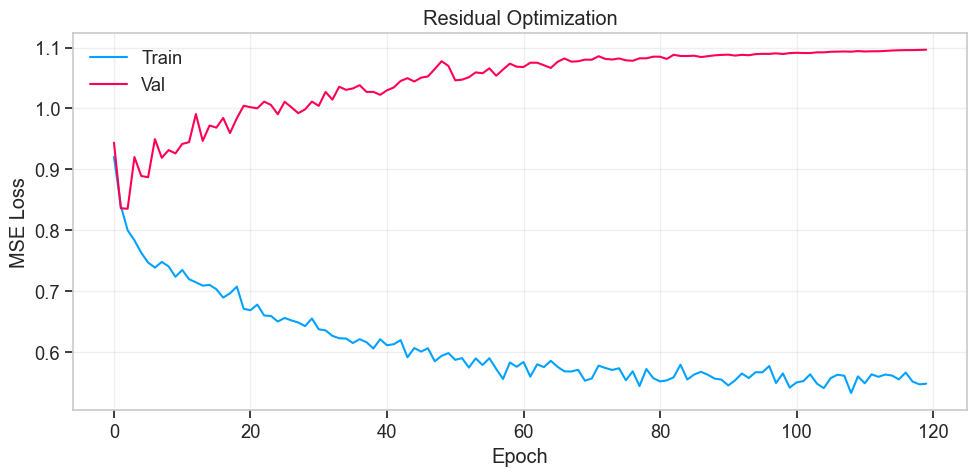

In [22]:
HIDDEN_DIM = best_params.get('hidden_dim', 32)
LR = best_params.get('lr', 0.005)
EPOCHS = 120

model = HybridLSTM(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)

train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    batch_losses = []
    
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = criterion(val_preds, y_test_tensor)
    
    scheduler.step(val_loss)
    train_losses.append(np.mean(batch_losses))
    val_losses.append(val_loss.item())
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1} | Val MSE: {val_loss.item():.5f}")

plt.figure(figsize=(10, 5))
TRAIN_COLOR = "#00A2FF"
VAL_COLOR   = "#FF0055"
plt.plot(train_losses, label="Train", color=TRAIN_COLOR, linewidth=1.5)
plt.plot(val_losses, label="Val", color=VAL_COLOR, linewidth=1.5)

plt.title("Residual Optimization")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(frameon=False)
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig("../results/residual_training_curve.png", dpi=300)
plt.show()

After training, the predicted residuals are mapped back into seconds and added to the current Ao5 to reconstruct the forecasted next Ao5. The resulting LSTM achieves an MAE of about 0.73 seconds versus 0.76 for the naive baseline, which is roughly a 4% reduction in error. That scale of improvement is small in absolute terms but meaningful in context, because it is competing against a already-strong baseline and the target itself is noisy. The forecast plot shows the model tracking the overall shape of the Ao5 series, including the major peaks and troughs, with deviations that are on the order of a few tenths of a second rather than full seconds.

Naive Baseline: 0.7571s
LSTM Model:     0.7271s
Improvement:    0.0301s
Lift:         3.97%


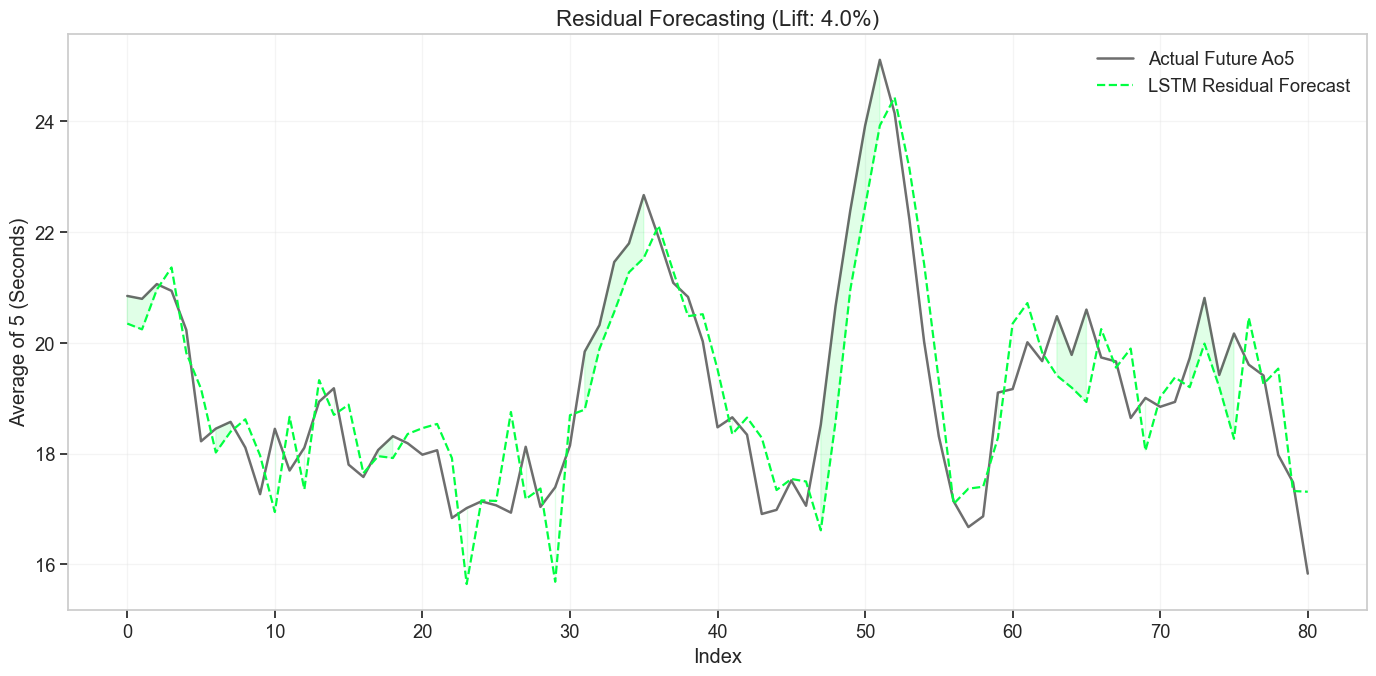

In [23]:
model.eval()
with torch.no_grad():
    pred_diff_scaled = model(X_test_tensor).numpy()

pred_diff = y_scaler.inverse_transform(pred_diff_scaled)
current_ao5 = test_df['mean_5'].values[SEQ_LENGTH:].reshape(-1, 1)
actual_next_ao5 = test_df['target_ao5_raw'].values[SEQ_LENGTH:].reshape(-1, 1)

final_predictions = current_ao5 + pred_diff

lstm_mae = mean_absolute_error(actual_next_ao5, final_predictions)
improvement = naive_mae - lstm_mae
lift_pct = (improvement / naive_mae) * 100

print(f"Naive Baseline: {naive_mae:.4f}s")
print(f"LSTM Model:     {lstm_mae:.4f}s")
print(f"Improvement:    {improvement:.4f}s")
print(f"Lift:         {lift_pct:.2f}%")


zoom = 100
plt.figure(figsize=(14, 7))

ACTUAL_COLOR = "#4A4A4A"
PRED_COLOR   = "#00FF41"

plt.plot(
    actual_next_ao5[:zoom],
    label="Actual Future Ao5",
    color=ACTUAL_COLOR,
    linewidth=1.8,
    alpha=0.8
)

plt.plot(
    final_predictions[:zoom],
    label="LSTM Residual Forecast",
    color=PRED_COLOR,
    linewidth=1.6,
    linestyle="--"
)
plt.fill_between(
    range(len(final_predictions[:zoom])),
    actual_next_ao5[:zoom].flatten(),
    final_predictions[:zoom].flatten(),
    where=(final_predictions[:zoom].flatten() < actual_next_ao5[:zoom].flatten()),
    color=PRED_COLOR,
    alpha=0.12
)

plt.title(f"Residual Forecasting (Lift: {lift_pct:.1f}%)", fontsize=16)
plt.xlabel("Index")
plt.ylabel("Average of 5 (Seconds)")
plt.grid(True, color="#DDDDDD", alpha=0.30)
plt.legend(frameon=False)

plt.tight_layout()


plt.savefig("../results/residual_forecast_curve.png", dpi=300)
plt.show()


The ensemble combines the LSTM forecast with the naive baseline using the model’s estimate of tilt probability as a mixing weight. The motivation behind creating this new model is that the the LSTM tends to help most during unstable stretches where the next solve deviates sharply from the recent average, while the naive baseline is more reliable during steady periods where the Ao5 barely moves. Instead of forcing one model to handle every regime, the ensemble uses the HMM’s state probabilities to decide when to lean toward each one.  When the tilt probability is high, the series is likely accelerating or breaking down, so the LSTM receives more weight. When tilt probability is low, the naive forecast remains competitive because the next Ao5 is usually close to the current one. This weighting scheme avoids over-committing to either model and prevents the instability you’d get from using the LSTM alone. The result is a noticeable reduction in MAE relative to the naive baseline. The lag test also shows that the ensemble tracks the direction of movement in real time rather than trailing it, which matters because visually I noticed that the model might just be following the real times but it appears to actually be predicting based on the correlation.

Naive MAE:   0.7571s
Dynamic MAE: 0.7080s
Improvement: 6.49%
Correlation at Lag 0 (Real-Time): 0.882
Correlation at Lag 1 (Delayed):   0.684


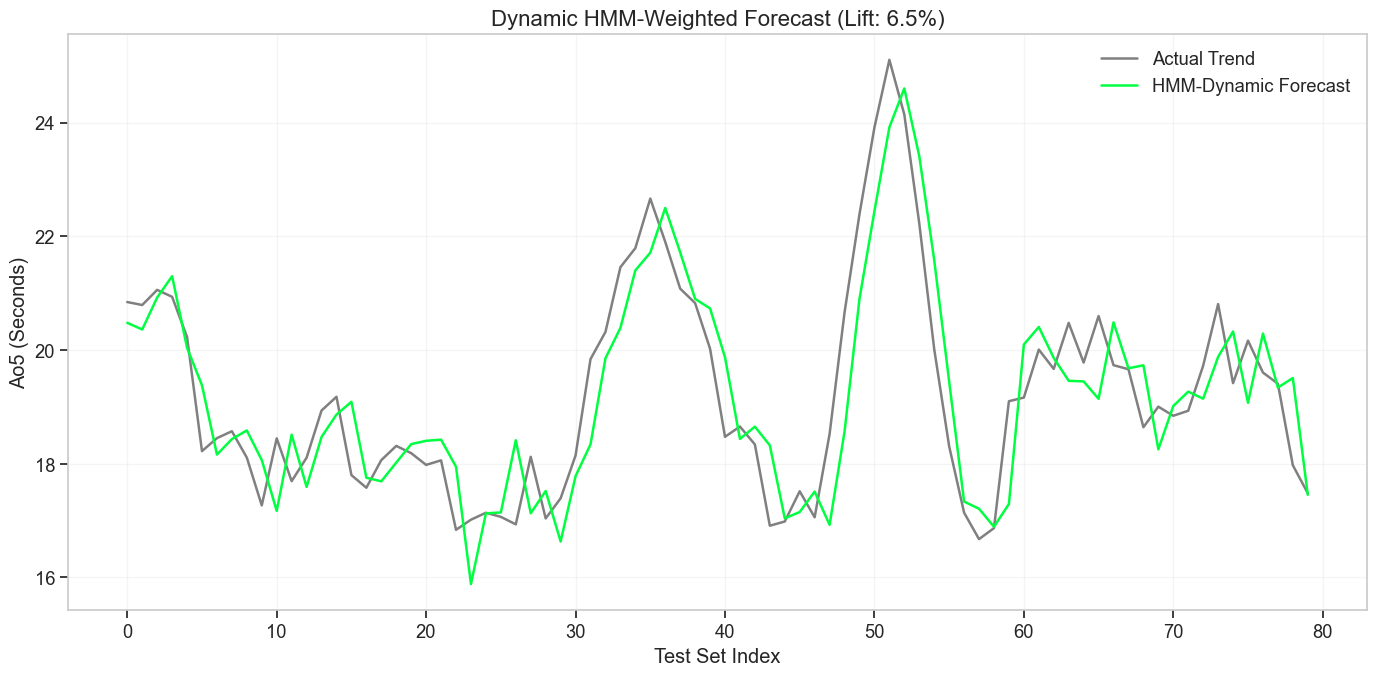

In [24]:
tilt_probs = test_df['prob_tilt'].values[SEQ_LENGTH:].reshape(-1, 1)

lstm_weight = np.clip(tilt_probs, 0.3, 0.8)
naive_weight = 1.0 - lstm_weight

true_values = actual_next_ao5
lstm_preds_aligned = final_predictions
naive_preds_aligned = current_ao5 

dynamic_preds = (lstm_weight * lstm_preds_aligned) + (naive_weight * naive_preds_aligned)

dynamic_mae = mean_absolute_error(true_values, dynamic_preds)
improvement = naive_mae - dynamic_mae
lift_pct = (improvement / naive_mae) * 100

print(f"Naive MAE:   {naive_mae:.4f}s")
print(f"Dynamic MAE: {dynamic_mae:.4f}s")
print(f"Improvement: {lift_pct:.2f}%")

def cross_corr(a, b):
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    return correlate(a, b, mode='full')

cc = cross_corr(true_values.flatten(), dynamic_preds.flatten())
center = len(cc) // 2
corr_lag_0 = cc[center]
corr_lag_1 = cc[center + 1]

print(f"Correlation at Lag 0 (Real-Time): {corr_lag_0:.3f}")
print(f"Correlation at Lag 1 (Delayed):   {corr_lag_1:.3f}")

zoom = 80
plt.figure(figsize=(14, 7))

ACTUAL_COLOR  = "#4A4A4A"
DYNAMIC_COLOR = "#00FF41"

plt.plot(
    true_values[:zoom],
    label="Actual Trend",
    color=ACTUAL_COLOR,
    alpha=0.7,
    linewidth=1.8,
)

plt.plot(
    dynamic_preds[:zoom],
    label="HMM-Dynamic Forecast",
    color=DYNAMIC_COLOR,
    linewidth=1.8,
)

plt.title(f"Dynamic HMM-Weighted Forecast (Lift: {lift_pct:.1f}%)", fontsize=16)
plt.ylabel("Ao5 (Seconds)")
plt.xlabel("Test Set Index")

plt.grid(True, color="#DDDDDD", alpha=0.30)
plt.legend(frameon=False)

plt.tight_layout()
plt.savefig("../results/final_dynamic_forecast.png", dpi=300)
plt.show()
